In [4]:
import os, random, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import albumentations as A
import webdataset as wds


import csv
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Found device: {device}")
batch_size = 32

Found device: cuda:0


In [87]:
def save_model(model_state, model_name, suffix, path="."):
    model_path = os.path.join(path, f"{model_name}_{suffix}.pth")
    torch.save(model_state.state_dict(), model_path)


def train(
    model, 
    trainloader, 
    validloader, 
    optimizer, 
    n_epochs, 
    n_iters, 
    model_name, 
    verbose=False
):
    model.train()
    criterion = nn.CrossEntropyLoss()
    global_iter = 0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print(f"Epoch #: {epoch}")
        running_loss = 0.0
        for i, batch in enumerate(trainloader, 0):
            global_iter += 1
            if global_iter == n_iters:
                acc = eval_acc(validloader, model, verbose=True)
                save_model(model, model_name=model_name, suffix=f"ep_last")
                return model, acc
            # get the inputs; data is a list of [inputs, labels]
            images = batch[0].to(device)
            meta = batch[1]
            labels = torch.tensor([float(x) for x in meta["Pneumonia"]]).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, _ = model(images)
            loss = criterion(outputs, labels.long() + 1) # account for -1 in label
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 500 == 499:    # print every 500 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0
        acc = eval_acc(validloader, model, verbose=verbose)
        # save_model(model, model_name=model_name, suffix=f"ep_{epoch}")

    print('Finished Training')
    return model, acc   


def eval_acc(testloader, model, verbose=False):
    model.eval()
    y_trues, y_preds = [], []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch in testloader:
            images = batch[0].to(device)
            meta = batch[1]
            labels = torch.tensor([float(x) for x in meta["Pneumonia"]]).to(device) + 1
            # calculate outputs by running images through the network 
            outputs, _ = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            y_trues.extend(labels.cpu().detach().numpy().tolist())
            y_preds.extend(predicted.cpu().detach().numpy().tolist())

    if verbose:
        print(f"Accuracy: {metrics.accuracy_score(y_trues, y_preds):.3f}")
        print(f"F1 Score: {metrics.f1_score(y_trues, y_preds, average='macro'):.3f}")
        print()
    return metrics.accuracy_score(y_trues, y_preds)

In [110]:
shard_root_path = "/l/Work/aalto/chest-xray-ssl/input/chexpert-shards/"
n_shards = len([p for p in os.listdir(shard_root_path) if 'train' in p])
train_start = str(0).zfill(6)
train_end = str(n_shards-2).zfill(6)
dev_start = str(n_shards-1).zfill(6)

train_shards = os.path.join(
    shard_root_path, f"chexpert-train-{{{train_start}..{train_end}}}.tar")
dev_shard = os.path.join(
    shard_root_path, f"chexpert-train-{dev_start}.tar")


In [112]:
# train_url = "/l/Work/aalto/chest-xray-ssl/input/chexpert-shards/chexpert-train-{000000..000021}.tar"
# val_url = "/l/Work/aalto/chest-xray-ssl/input/chexpert-shards/chexpert-train-000022.tar"

def image_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


preproc = transforms.Compose([
  transforms.RandomResizedCrop(128),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])


train_dataset = wds.WebDataset(train_shards)\
    .shuffle(1000)\
    .decode("pil")\
    .rename(image="jpg;png", meta="json")\
    .map_dict(image=preproc)\
    .to_tuple("image", "meta")

val_dataset = wds.WebDataset(dev_shard)\
    .shuffle(1000)\
    .decode("pil")\
    .rename(image="jpg;png", meta="json")\
    .map_dict(image=preproc)\
    .to_tuple("image", "meta")
    
train_dataloader = torch.utils.data.DataLoader(
  train_dataset, 
  num_workers=2, 
  batch_size=16
)

val_dataloader = torch.utils.data.DataLoader(
  val_dataset, 
  num_workers=2, 
  batch_size=16
)

{'Sex': ['Male', 'Female', 'Female', 'Male', 'Female', 'Male', 'Female', 'Female', 'Male', 'Male', 'Female', 'Male', 'Male', 'Male', 'Male', 'Male'], 'Age': ['68', '56', '32', '73', '58', '45', '68', '74', '90', '55', '51', '73', '34', '79', '38', '18'], 'Frontal/Lateral': ['Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Frontal', 'Lateral', 'Lateral', 'Frontal', 'Frontal'], 'AP/PA': ['AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'AP', 'nan', 'nan', 'AP', 'AP'], 'No Finding': ['0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0'], 'Enlarged Cardiomediastinum': ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '0.0', '1.0', '0.0'], 'Cardiomegaly': ['0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0'], 'Lung Opacity': ['1.0', '1.0', '0.0',

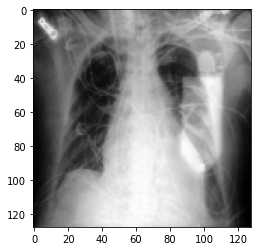

In [101]:
batch = next(iter(train_dataloader))
print(batch[1])
plt.imshow(np.transpose(batch[0][0].numpy(), (1, 2, 0)))

In [102]:
class Resnet34(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = models.resnet34(pretrained=True)
        self.encoder.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        intermediate_outputs = []
        inter_x = self.encoder.maxpool(self.encoder.relu(
            self.encoder.bn1(self.encoder.conv1(x))
        ))
        intermediate_outputs.append(inter_x)

        for layer in [
                      self.encoder.layer1,
                      self.encoder.layer2,
                      self.encoder.layer3,
                      self.encoder.layer4
                      ]:
            for res_block in layer:
                inter_x = res_block(inter_x)
                intermediate_outputs.append(inter_x)
            
            x = self.encoder(x)
            return x, intermediate_outputs

In [103]:
def train_domainnet(
    train_size,
    img_size, 
    optimizer, 
    model, 
    save_model_name, 
    batch_size=64,
    verbose=False
):
    model = model.to(device)
    domainnet_optimizer = optimizer
    domainnet_trainloader, domainnet_validloader, domainnet_testloader = train_dataloader, val_dataloader, val_dataloader
    domainnet_trained_resnet = train(
        model, 
        trainloader=domainnet_trainloader, 
        validloader=domainnet_validloader, 
        optimizer = domainnet_optimizer,
        n_epochs=1000, 
        n_iters=1000,
        model_name=save_model_name,
        verbose=verbose
    )

    # test acc
    domainnet_trained_resnet = model.to(device)
    domainnet_trained_resnet.load_state_dict(torch.load(f'./{save_model_name}_ep_last.pth'))
    test_acc = eval_acc(domainnet_testloader, domainnet_trained_resnet, verbose=True)

    return test_acc

In [104]:
resnet34 = Resnet34(num_classes=3)
uniform_optimizer = optim.AdamW(
            resnet34.parameters(), 
            lr=1e-3, 
            betas=(0.9, 0.999), 
            weight_decay=0.0
)
# uniform_optimizer = resnet18.configure_uniform_optimizer(lr=1e-3, weight_decay=0.0)
N = 10000
train_domainnet(
    train_size=N,
    img_size=64, 
    optimizer=uniform_optimizer, 
    model=resnet34, 
    save_model_name=f"resnet34_N{N}", 
    batch_size=64,
    verbose=True
)

Epoch #: 0
[1,   500] loss: 0.464
Accuracy: 0.884
F1 Score: 0.313

Accuracy: 0.884
F1 Score: 0.313



0.8842999414176919